In [1]:
import multiprocessing
from functools import reduce
import operator
import random

import numpy as np
import matplotlib.pyplot as plt
from neuron import h

%load_ext autoreload
%autoreload 2

from GrC import GrC
from Golgi import Golgi

In [2]:
np.random.normal(8.5, 1)  # 

9.921920700715615

In [2]:
# Instantiation of the cell templates
golgi_cells = [[Golgi(i, morpho) for i in range(count)] for morpho, count in (
    (1, 3),  # 3 of morpho 1
    (2, 2),  # 2 of morpho 2
)]
golgi_cells = reduce(operator.concat, golgi_cells)

grc_cells = [[GrC(i, subtype) for i in range(count)] for subtype, count in (
    ("regular", 2),
    ("mild", 3),
    ("adapting", 4),
    ("accelerate", 1),
)]
grc_cells = reduce(operator.concat, grc_cells)

ascending_axons = sum((grc_cell.HD_aa for grc_cell in grc_cells), [])



5394 lines read

5394 lines read

5394 lines read

5456 lines read

morphology/pair-140514-C2-1_split_2.asc problems


Main branch starting at line 58 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 2375 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

5456 lines read

morphology/pair-140514-C2-1_split_2.asc problems


Main branch starting at line 58 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 2375 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read


In [3]:
# Fixed time step only
time_step = h.CVode()
time_step.active(0)  # 0 fixed step, 1 variable time step

# Activate the multisplit to use half of cores available (with a max of 8)
cpu = multiprocessing.cpu_count() // 2
h.load_file("parcom.hoc")
p = h.ParallelComputeTool()
p.change_nthread(min(8, cpu), 1)
p.multisplit(1)

0.0

In [4]:
# Number of spikes, interval, starting moment, delay factor to activate two different types of synapses in two different moments, presence of noise
# See the defaults in create_syn_stims()
synapse_data_pf = {'number': 5, 'interval': 10, 'start': 100}
synapse_data_mf = {'number': 5, 'interval': 10, 'start': 100}
synapse_data_aa = {'number': 5, 'interval': 10, 'start': 100}

stims = []
ncs = []

def create_syn_stims(synapses, number=5, interval=10, start=100, delay=0, noise=0):
    totalstim = int(h.tstop / start)
    for j in range(totalstim):
        s = h.NetStim()
        s.interval = interval
        s.number = number
        s.noise = noise
        s.start = start * (totalstim - j) + delay
        stims.append(s)
        ncs.extend(h.NetCon(s, syn.input, 0, 0.1, 1) for syn in synapses)
    return stims, ncs

frequencies = [200, 100, 50, 25, 16.6, 12.5]

for j, grc_cell in enumerate(grc_cells):
    # number of AMPA syn, NMDA syn, dend number from 0 to 3
    grc_cell.createsyn(1, 1, [0, 1], [0, 1])

    # for i, frequency in enumerate(frequencies):
    stims = create_syn_stims(grc_cell.MF_GrC_AMPA + grc_cell.MF_GrC_NMDA_B)
    spk_stim_mf, spk_nc_mfsyn = create_syn_stims(grc_cell.MF_GrC_AMPA + grc_cell.MF_GrC_NMDA_B, **synapse_data_mf)


# for a, ascending_axon in enumerate(ascending_axons):

#     ascending_axon.createsyn(GrC_n=len(grc_cells)*1) # TODO Find how many are synapsing 

#     for i, grc_cell in enumerate(grc_cells):
#         aa_i = random.randrange(0, len(grc_cell.HD_aa))
#         aa = grc_cell.HD_aa[aa_i]
#         sections = [aa[random.randrange(len(aa))] for _ in ascending_axons.L_AA]
#         ncs.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
#                    for syn, sec in zip(ascending_axons.L_AA, sections))

# for p, parallel_fiber in enumerate(parallel_fibers):

#     parallel_fiber.createsyn(pf_n=len(grc_cells)*1) # TODO Find how many are synapsing 

#     for i, parallel_fiber in enumerate(parallel_fibers):
#         pf_i = random.randrange(0, len(parallel_fibers.HD_pf))
#         pf = parallel_fibers.HD_pf[pf_i]
#         sections = [pf[random.randrange(len(pf))] for _ in parallel_fibers.L_PF] # was this made or is this L_PF somewhere?
#         ncs.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
#                    for syn, sec in zip(parallel_fibers.L_PF, sections))

for j, golgi_cell in enumerate(golgi_cells):

    # number of AMPA syn, NMDA syn, dend number from 0 to 3

    # Create the synapses (max used in the paper: 89, 20, 20)
    # Not included: inhibitory synapses (up to 20 in the paper)

    # 1 Parallel Fiber reaches 8 Golgi cells, each one synapses ~3 times onto a Golgi cell, 400 Parallel Fibers connect to a single Golgi cell

    # 1 Ascending Axon reaches 23 Golgi cells, each one synapses ~1 times onto a Golgi cell. About 400 ascending axons to a golgi cell

    # 1 golgi cell reaches 40 mossy fibers, each one synapses ~1 time onto a golgi cell, one golgi cell recieves input 
    # from 40 different mossy fibers

    golgi_cell.createsyn(mf_n=0,
                         pf_n=len(grc_cells)*3,
                         aa_n=len(ascending_axons)*((len(ascending_axons) // 4))) 
    
    # Parallel Fiber Connections
    for i, grc_cell in enumerate(grc_cells):
        pf_i = random.randrange(0, len(grc_cell.HD_pf))
        pf = grc_cell.HD_pf[pf_i]
        sections = [pf[random.randrange(len(pf))] for _ in golgi_cell.L_PF] # was this made or is this L_PF somewhere?
        ncs.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
                   for syn, sec in zip(golgi_cell.L_PF, sections))

        # AA
        ...

    # Ascending Axons Connections
    # for i, ascending_axon in enumerate(ascending_axons):
    #     aa_i = random.randrange(0, len(ascending_axons.HD_aa))
    #     aa = ascending_axons.HD_aa[aa_i]
    #     sections = [aa[random.randrange(len(aa))] for _ in ascending_axons.L_AA]
    #     ncs.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
    #                for syn, sec in zip(ascending_axons.L_AA, sections))


In [5]:
# Basic properties of the simulation
h.dt = 0.025    # change in time between steps (ms)
h.celsius = 32  # temperature of the neurons (*C)
h.v_init = -65  # initial membrane potential (mV)

h.tstop = 1000  # time to stop the entire simulation (ms)
time = h.Vector()
time.record(h._ref_t)
h.finitialize()
h.run()

0.0

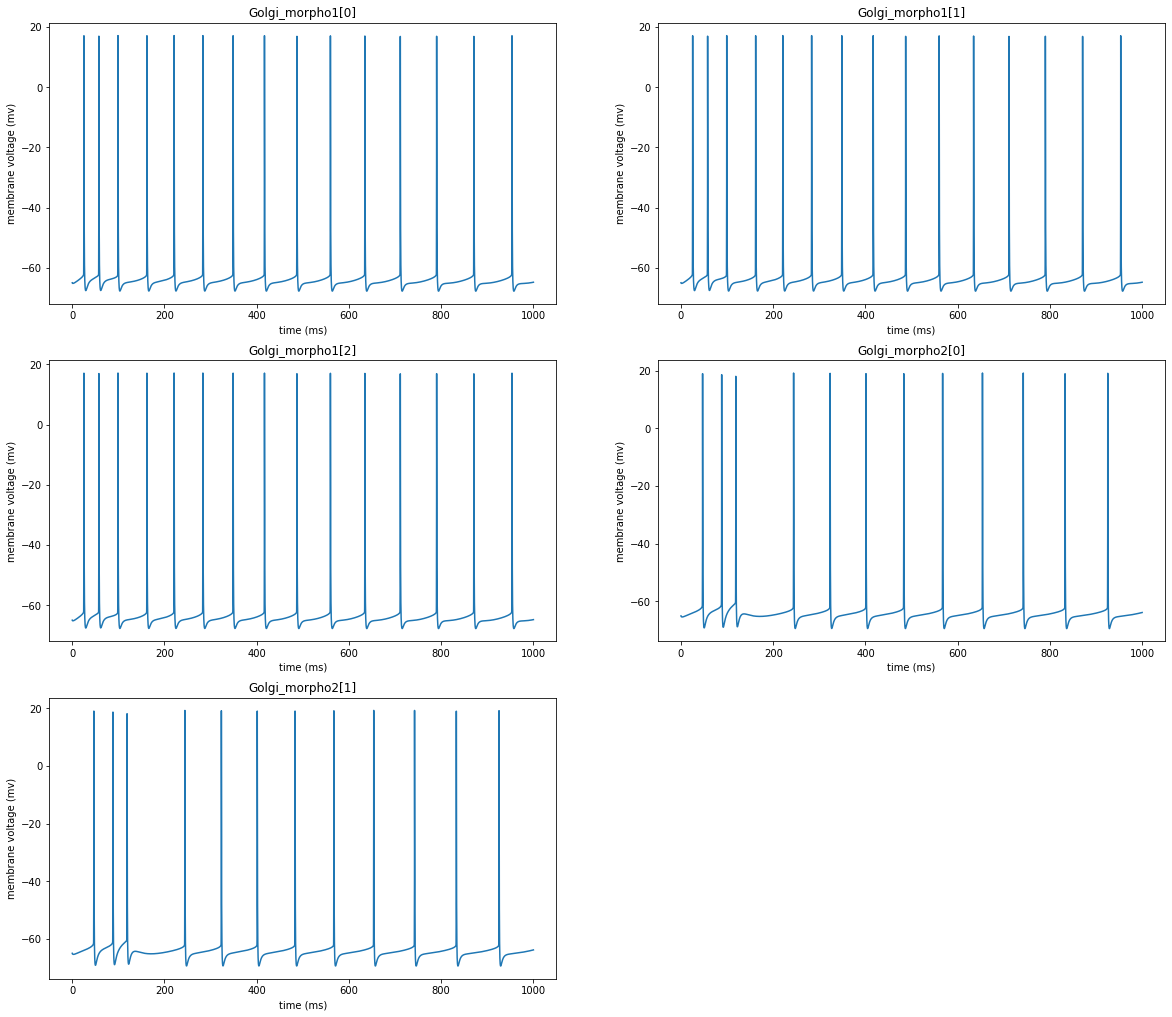

In [6]:
plt.figure(figsize=(20, 30))
for j, golgi_cell in enumerate(golgi_cells):
    plt.subplot(len(golgi_cells), 2, j + 1)
    plt.plot(time, np.array(golgi_cell.vm), label=str(golgi_cell))
    time = np.array(time)
    plt.title(f"{golgi_cell}")
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv)")

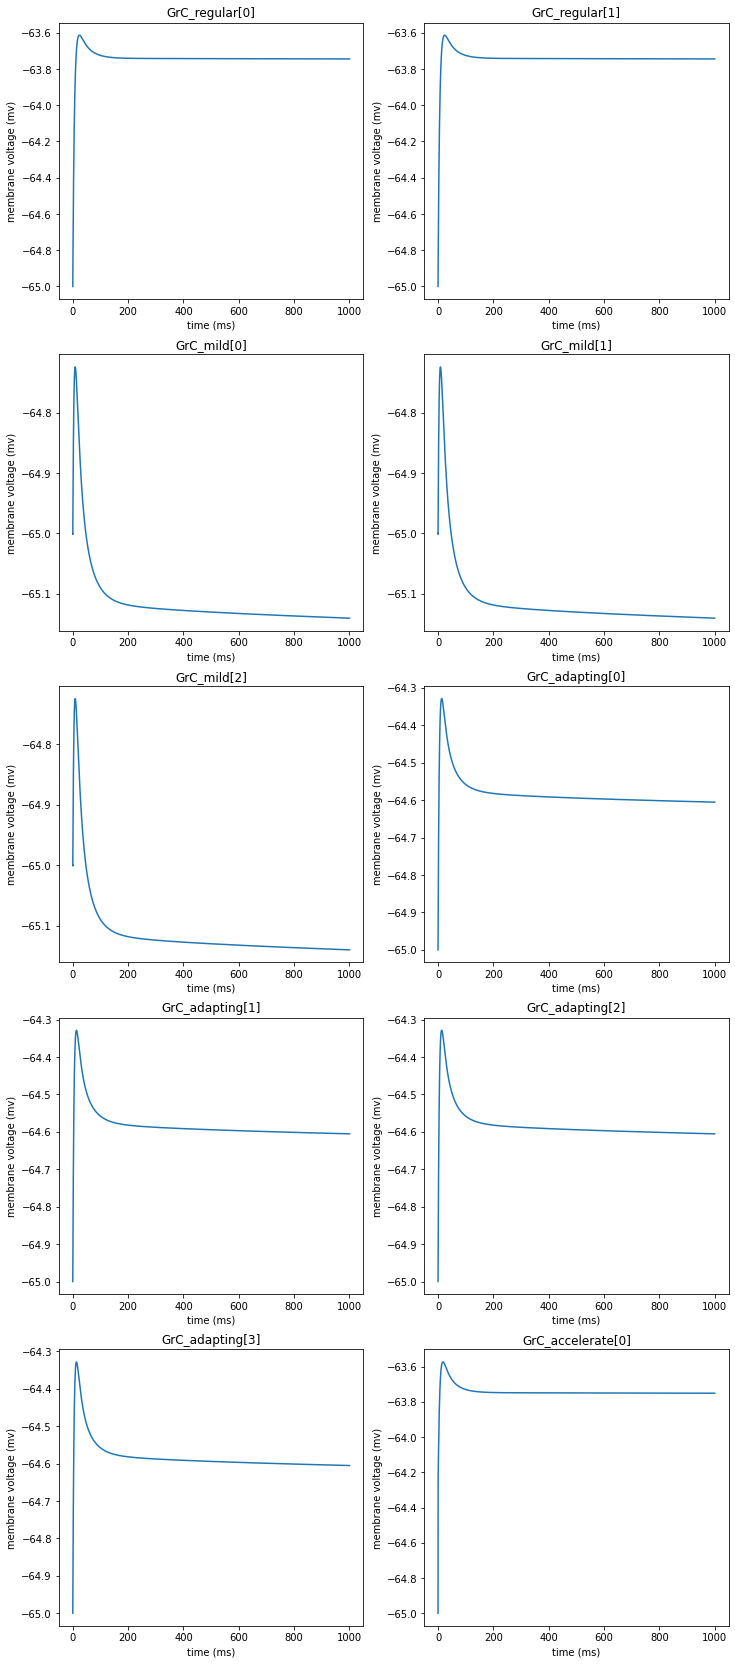

In [7]:
plt.figure(figsize=(12, 60))
for j, grc_cell in enumerate(grc_cells):
    plt.subplot(len(grc_cells), 2, j + 1)
    plt.plot(time, np.array(grc_cell.vm_soma), label=str(grc_cell))
    time = np.array(time)
    plt.title(f"{grc_cell}")
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv)")